#### Timeseries clustering tests
Just testing various techniques

See
- https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering

In [113]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

Load some timeseries data for testing. 

https://www.kaggle.com/datasets/census/retail-and-retailers-sales-time-series-collection?resource=download

Note some of the timeseries are of varying length, we did some preprocessing here...

In [114]:
mySeries = []
mySeries = []
namesofMySeries = []
for filename in os.listdir("timeseries-data/"):
    if filename.endswith(".csv"):
        df = pd.read_csv("timeseries-data/" + filename)
        df = df.loc[:,["date", "value"]]
        
        # While we are at it I just filtered the columns that we will be working on
        df.set_index("date", inplace=True)
        
        # set the date columns as index
        df.sort_index(inplace=True)
        
        # and lastly, ordered the data according to our date index
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

In [127]:
rawTimeseries = []
normalizedTimeseries = []

### Assume equal length, drop dates
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    normalizedTimeseries.append(MinMaxScaler().fit_transform(mySeries[i]))
    normalizedTimeseries[i]= normalizedTimeseries[i].reshape(len(normalizedTimeseries[i]))
    rawTimeseries.append(mySeries[i].get("value").tolist())

print(len(mySeries))
print(len(rawTimeseries))

23
23


#### Plot data series
Just to get a sense of what stuff look like

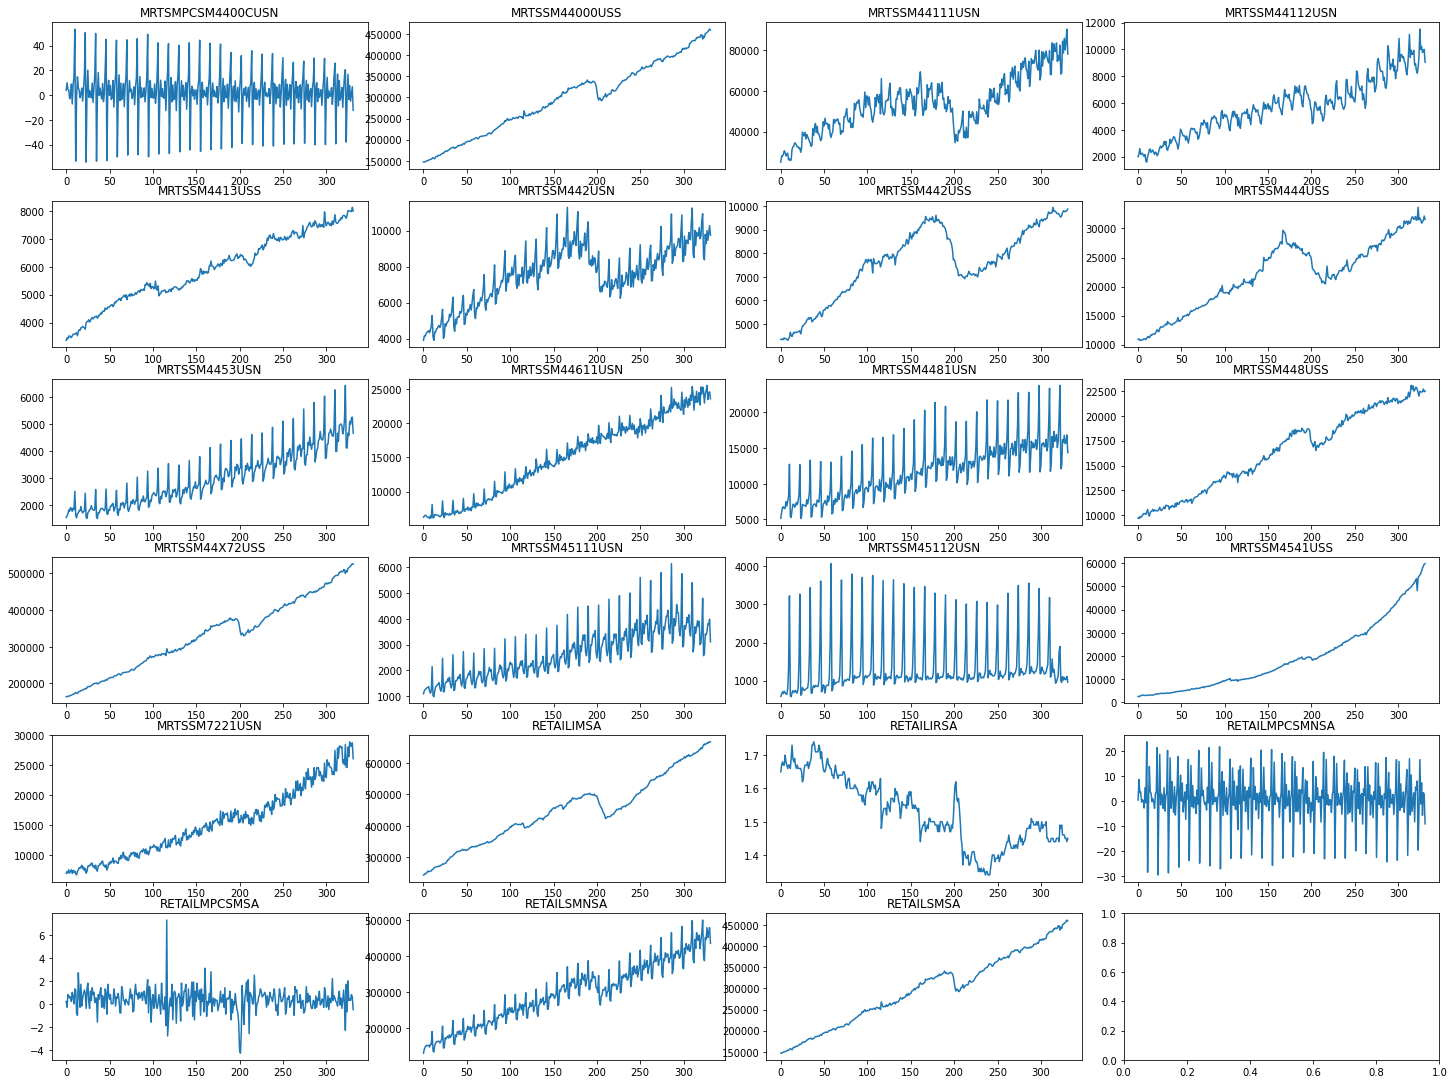

In [128]:
fig, axs = plt.subplots(6,4,figsize=(20,15))
# fig.suptitle('Series')
fig.tight_layout()
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(rawTimeseries): # pass the others that we can't fill
            continue
        axs[i, j].plot(rawTimeseries[i*4+j])
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

#### Show the result of noramlized vs non-normalized

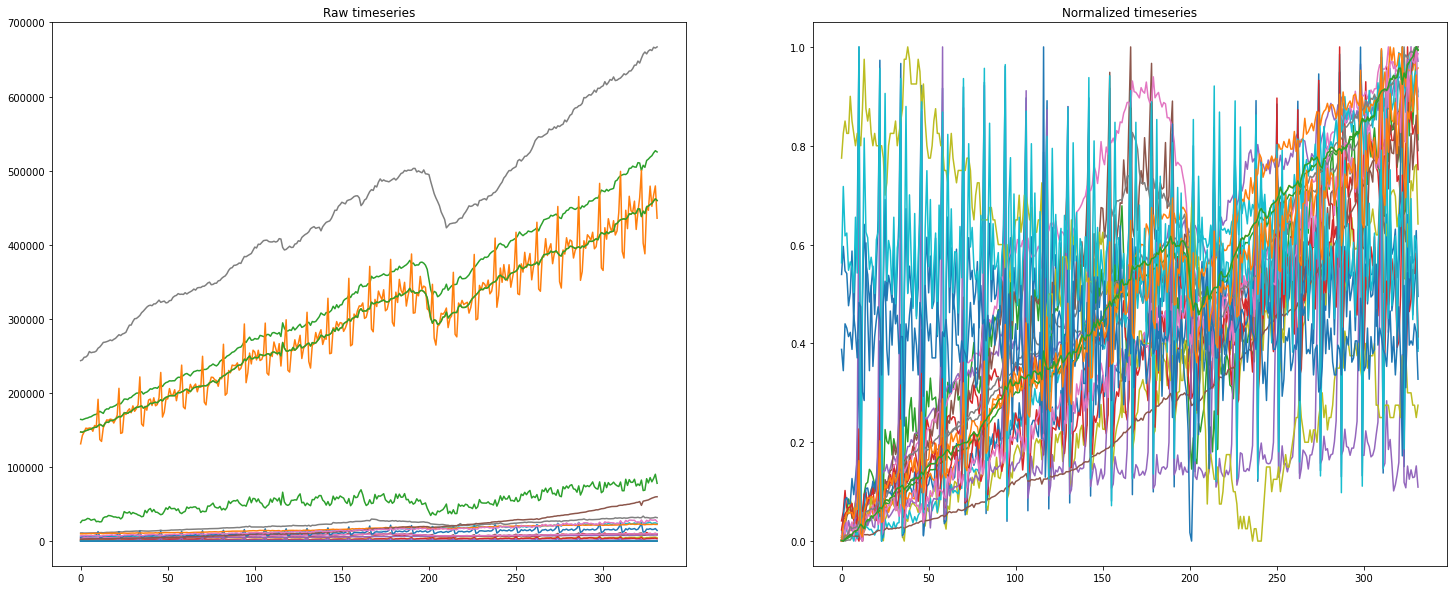

In [129]:
######################################
## Normalize
######################################
"""
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))
"""
######################################
## Plot
######################################
"""
plt.figure(figsize=(20, 12))
plt.tick_params(
    axis='x', bottom=False, top=False, labelbottom=False)
for i in range(len(mySeries)):
    plt.plot(mySeries[i], label ='y1')
"""
    
    
fig, axs = plt.subplots(1, 2, figsize=(25,10))

# Raw timeseries
for i in range(len(rawTimeseries)):
    axs[0].plot(rawTimeseries[i])
axs[0].title.set_text("Raw timeseries")

# Normalized timeseries
for i in range(len(rawTimeseries)):
    axs[1].plot(normalizedTimeseries[i])
axs[1].title.set_text("Normalized timeseries")  

#### Using self-organizing maps to cluster time series
https://en.wikipedia.org/wiki/Self-organizing_map

In [167]:
### Calculate for noramlized timeseries
# som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(rawTimeseries))))

# som = MiniSom(som_x, som_y, len(rawTimeseries[0]), sigma=0.3, learning_rate = 0.1)
# som.random_weights_init(rawTimeseries)
# som.train(rawTimeseries, 500)


def train_and_fit_som(data):
    som_x = som_y = 3 # Just playing around
    som = MiniSom(som_x, som_y, len(data[0]), sigma=0.3, learning_rate = 0.1)
    som.random_weights_init(data)
    som.train(data, 500)
    return som

In [168]:
som_normalized = train_and_fit_som(normalizedTimeseries)
som_raw = train_and_fit_som(rawTimeseries)

#### Peek at a few SOM output
The raw data timeseries are in the left column, while the noramlized timeseries are in the right column. Note the left/right charts are **NOT** comparable as they are created with different instances of self-organizing maps.

In [174]:
map_raw = som_raw.win_map(rawTimeseries)
map_normalized = som_normalized.win_map(normalizedTimeseries)

print("=== Raw ===")
for c in map_raw.keys():
    print(f"Cluster {c} - {len(map_raw[c])}")
    
print("=== Noramlized ===")
for c in map_normalized.keys():
    print(f"Cluster {c} - {len(map_normalized[c])}")    

=== Raw ===
Cluster (1, 2) - 1
Cluster (0, 1) - 5
Cluster (1, 0) - 1
Cluster (2, 2) - 4
Cluster (0, 0) - 5
Cluster (0, 2) - 3
Cluster (1, 1) - 1
Cluster (2, 1) - 3
=== Noramlized ===
Cluster (0, 1) - 4
Cluster (2, 1) - 7
Cluster (0, 0) - 1
Cluster (2, 0) - 1
Cluster (0, 2) - 3
Cluster (1, 0) - 4
Cluster (1, 2) - 1
Cluster (1, 1) - 1
Cluster (2, 2) - 1


In [209]:
def plot_win_map(cluster, m1, m2):
    fig, axs = plt.subplots(1, 2, figsize=(25,5))
    if cluster in m1.keys():
         title = f"{len(m1[cluster])} time series"
         axs[0].title.set_text(title)
         for series in m1[cluster]:
                axs[0].plot(series, c="#336699", alpha=0.5)
    if cluster in m2.keys():
         title = f"{len(m2[cluster])} time series"
         axs[1].title.set_text(title)
         for series in m2[cluster]:
                axs[1].plot(series, c="#FF00AA", alpha=0.5)

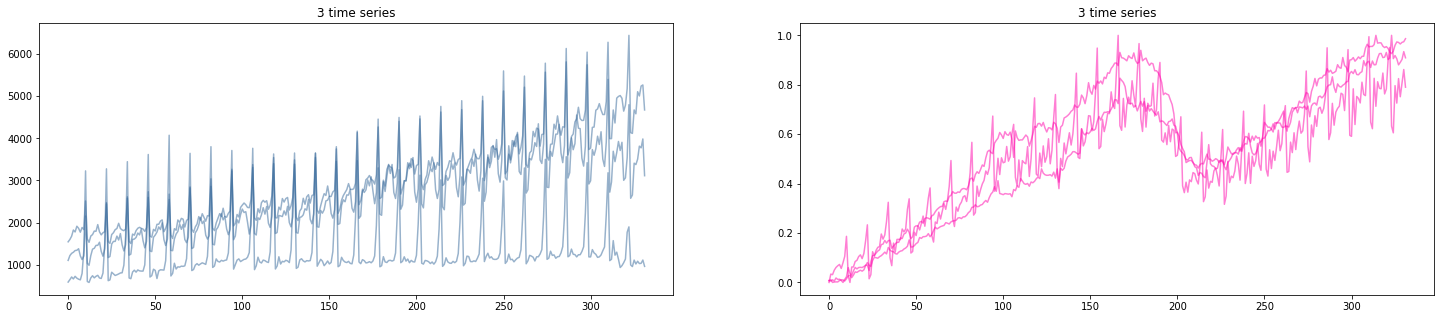

In [210]:
cluster = (0, 2)
plot_win_map(cluster, map_raw, map_normalized)

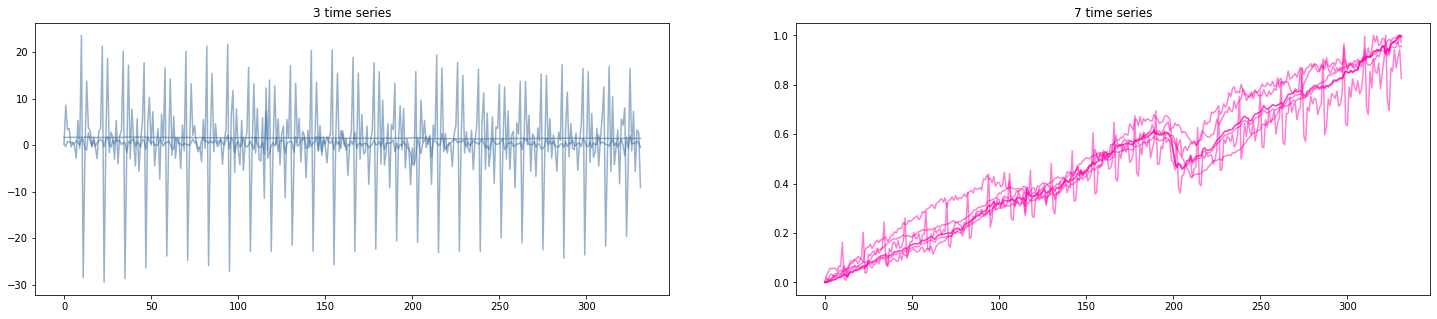

In [211]:
cluster = (2, 1)
plot_win_map(cluster, map_raw, map_normalized)

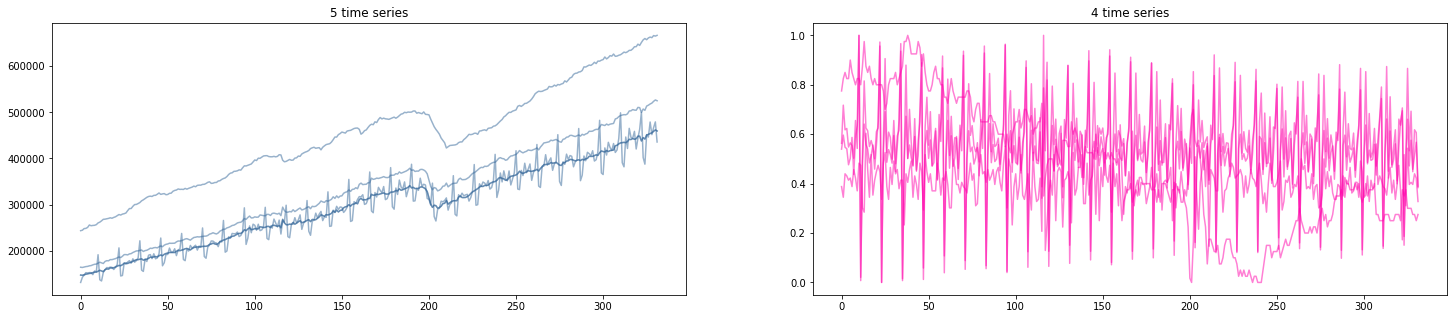

In [212]:
cluster = (0, 1)
plot_win_map(cluster, map_raw, map_normalized)